In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import glob
from scipy.ndimage.filters import gaussian_filter
from scipy.optimize import curve_fit

In [3]:
from astropy import coordinates
from astropy import units as u
from astropy.coordinates import ICRS

In [4]:
from scipy import linalg
from mpl_toolkits.mplot3d import Axes3D

In [5]:
figsize(10, 8)

In [6]:
freqs = [4.575, 5.625, 6.125, 7.175]
banks = ['A', 'B', 'C', 'D']

In [7]:
def naive_map(data,ra,dec,ra_num_bins=60,dec_num_bins=50):
    ra_bins = np.linspace(ra.min(),ra.max(),ra_num_bins)
    dec_bins = np.linspace(dec.min(),dec.max(),dec_num_bins)
    p,_,_ = np.histogram2d(ra,dec,bins=(ra_bins,dec_bins),weights=data)
    hits,_,_ = np.histogram2d(ra,dec,bins=(ra_bins,dec_bins))
    return p.T, hits.T, ra_bins, dec_bins

In [8]:
rc = 335.7133441444117
dc = 63.43802542905474

In [10]:
def calculate_sflux(bank='A', session='5', doplot=False, pixbeam=4., removeplane=False):
    dataf = np.load('/home/mabitbol/GBT-S140/datamaps/datamaps_'+bank+'_'+session+'.npz')
    tmask = dataf['tmask']
    ras = dataf['ras'][tmask]
    decs = dataf['decs'][tmask]
    calibrated = dataf['calibrated'][tmask]
    
    tmask2 = ~np.isnan(calibrated)
    ras = ras[tmask2]
    decs = decs[tmask2]
    calibrated = calibrated[tmask2] 
    
    if bank == 'A':
        cfreq = 4.575
    elif bank == 'B':
        cfreq = 5.625
    elif bank == 'C':
        cfreq = 6.125
    elif bank == 'D':
        cfreq = 7.175
    beam = 12.6 / cfreq
    
    # units !!
    # units now are Jy * beam area per pixel area
    beamarea = np.pi / (4. * np.log(2)) * beam**2
    pixelarea = pixbeam**2
    units = pixelarea / beamarea
    
    nrapix = int((ras.max() - ras.min()) / (pixbeam / 60.))
    ndecpix = int((decs.max() - decs.min()) / (pixbeam / 60.))
    
    datamap, hits, rabins, decbins = naive_map(calibrated, ras, decs, nrapix, ndecpix) 
    mask = hits == 0
    signal = np.zeros_like(datamap)
    signal[~mask] = datamap[~mask] / hits[~mask] * units
    
    signal = gaussian_filter(signal, beam/pixbeam)
    shits = gaussian_filter(hits, beam/pixbeam)
    signal[mask] = np.nan
    
    radius = np.sqrt( (ras-rc)**2 + (decs-dc)**2)
    rmask = radius <= 1.
    
    insidedata = np.zeros_like(calibrated)
    insidedata[rmask] = 10.
    innermap, innerhits, rabins, decbins = naive_map(insidedata, ras, decs, nrapix, ndecpix) 
    innerregion = innermap > 0
    
    annulus = (radius >= 80./60.) & (radius <= 2.)
    outerdata = np.zeros_like(calibrated)
    outerdata[annulus] = 10.
    outermap, outerhits, rabins, decbins = naive_map(outerdata, ras, decs, nrapix, ndecpix)
    outerregion = outermap > 0
    
    if removeplane:
        rabinsc = (rabins[1:] + rabins[:-1]) / 2.
        decbinsc = (decbins[1:] + decbins[:-1]) / 2.
        X, Y = np.meshgrid(rabinsc, decbinsc)
        XX = X.flatten()
        YY = Y.flatten()
        Z = signal.flatten()
        mask = ~np.isnan(Z) * (~innerregion.flatten()) * (~outerregion.flatten())
        data = np.c_[XX[mask], YY[mask], Z[mask]]
        data2 = np.c_[XX, YY, Z]
        A = np.c_[data[:, 0], data[:, 1], np.ones(data.shape[0])]
        C, _, _, _ = linalg.lstsq(A, data[:, 2])
        res = C[0] * X + C[1] * Y + C[2]
        signal -= res
    
    if doplot:
        figure()
        pc = pcolormesh(rabins, decbins, signal - np.nanmedian(signal[outerregion]))
        clim(-0.2, 0.2)
        cb = colorbar()
        xlabel('RA [degrees]')
        ylabel('DEC [degrees]')
        cb.set_label('Flux [Jy]')
        title('Bank '+bank)
    
    flux = np.nansum(signal[innerregion] - np.nanmedian(signal[outerregion]))
    print flux
    return signal, rabins, decbins, innerregion, outerregion

In [52]:
signal, rabins, decbins, innerregion, outerregion = calculate_sflux('A', '5', removeplane=False)

31.3715079664


In [54]:
np.nanmedian(signal[outerregion])

-0.0019692096837565717

In [61]:
signal, rabins, decbins, innerregion, outerregion = calculate_sflux('A', '5', removeplane=True)

41.6376508959


In [62]:
np.nanmedian(signal[outerregion])

-0.00049895006322644986

In [63]:
rabinsc = (rabins[1:] + rabins[:-1]) / 2.
decbinsc = (decbins[1:] + decbins[:-1]) / 2.

In [64]:
rdmesh = meshgrid(rabinsc, decbinsc)
radius_grid = np.sqrt( (rdmesh[0] - rc)**2 + (rdmesh[1] - dc)**2 ) 

In [65]:
rsig = signal.reshape(signal.size, )
radius = radius_grid.reshape(signal.size, )
x = zip(radius, rsig)
x.sort()
radsort, fluxsort = zip(*x)
radsort = np.array(radsort)
fluxsort = np.array(fluxsort)

In [66]:
mask = ~np.isnan(fluxsort)
rflux = np.cumsum(fluxsort[mask]+0.00049895006322644986)

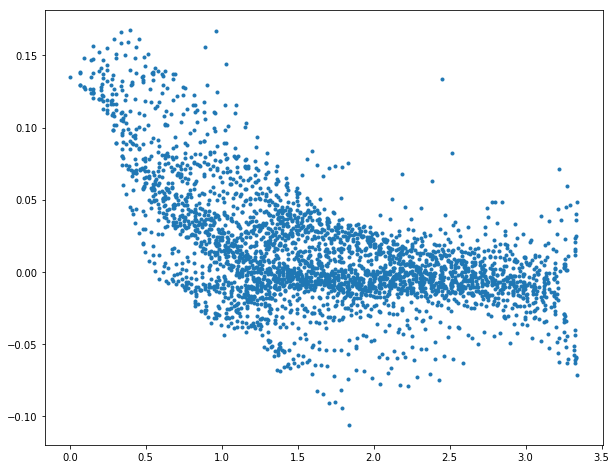

In [67]:
plot(radius, rsig, '.')

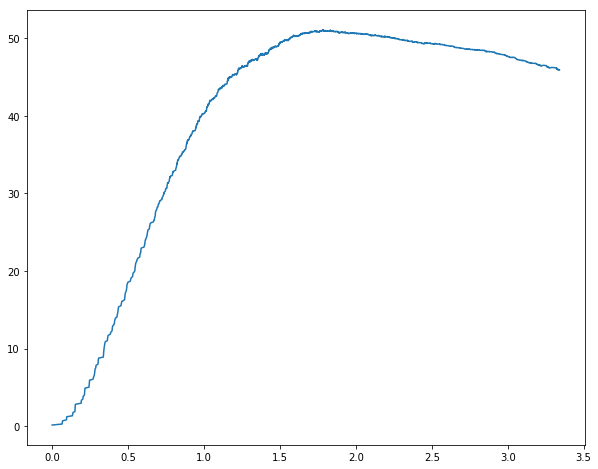

In [68]:
plot(radsort[mask], rflux)

In [45]:
np.isnan(fluxsort)

array([False, False, False, ...,  True,  True,  True], dtype=bool)

In [46]:
amask = (radsort > 80./60.) * (radsort < 2. ) 

In [47]:
np.nanmedian(fluxsort[amask])

-0.0031504499033931971

In [48]:
np.nanmean(fluxsort[amask])

-0.01254459677735935

In [49]:
rmask = radsort < 1. 

In [50]:
np.nansum(fluxsort[rmask])

29.3509645548015

In [51]:
np.nansum(fluxsort[rmask] - np.nanmedian(fluxsort[amask]))

31.471217339785124

In [52]:
np.nansum(fluxsort[rmask] - np.nanmean(fluxsort[amask]))

37.793478185964346